In [1]:
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from feadme.parser import Template, Disk, Parameter
from feadme.compose import evaluate_disk_model
import astropy.units as u
import astropy.constants as const
from feadme.models.hung_model import e_model

/Users/nmearl/code/feadme/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-12 03:14:14 | DEBUG    | Initializing...
2025-04-12 03:14:14 | DEBUG    | Backend: cpu
2025-04-12 03:14:14 | DEBUG    | Device count: 2
2025-04-12 03:14:14 | DEBUG    | Device: cpu
2025-04-12 03:14:14 | DEBUG    | Local device count: 2


In [2]:
c_cgs = const.c.cgs.value

redshift = 0.01
wave = np.linspace(6300, 6800, 100)
center = 6562.819

velocity = (wave - center) / center * c_cgs

nu = c_cgs / (wave * 1e-8)
nu0 = c_cgs / (center * 1e-8)
X = 1 - nu / nu0

In [3]:
disk_profile = Disk(
    name="halpha_disk",
    center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
    inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3),
    delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=5e2, high=1e5),
    inclination=Parameter(name="inclination", distribution="normal", low=0, high=np.pi / 2, loc=np.pi / 4, scale=np.pi / 8),
    sigma=Parameter(name="sigma", distribution="log_uniform", low=1e2, high=1e4),
    q=Parameter(name="q", distribution="uniform", low=0.5, high=4),
    eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1),
    apocenter=Parameter(name="apocenter", distribution="normal", low=0, high=2 * np.pi, loc=np.pi, scale=np.pi / 4),
    scale=Parameter(name="scale", distribution="uniform", low=0, high=1),
    offset=Parameter(name="offset", distribution="uniform", low=0, high=0.05, fixed=True, value=0)
)

template = Template(
    name="test",
    redshift=0.0,
    mjd=0,
    data_path="",
    disk_profiles=[
        disk_profile,
    ],
    line_profiles=[],
)

param_mods = {
    "halpha_disk_center": 6562.819,
    "halpha_disk_inner_radius": 500,
    "halpha_disk_outer_radius": 2500,
    "halpha_disk_inclination": np.pi / 6,
    "halpha_disk_sigma": 800,
    "halpha_disk_q": 3,
    "halpha_disk_eccentricity": 0.3,
    "halpha_disk_apocenter": np.pi / 2,
    "halpha_disk_scale": 1,
    "halpha_disk_offset": 0,
}

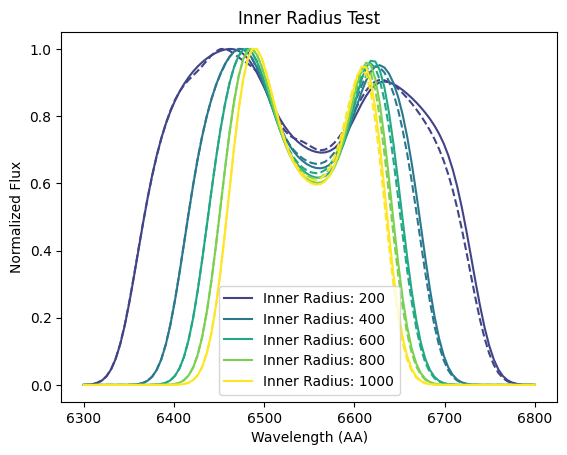

In [4]:
fig, ax = plt.subplots()

for inrad in [2e2, 4e2, 6e2, 8e2, 1e3]:
    pmod = param_mods.copy()
    pmod["halpha_disk_inner_radius"] = inrad
    flux, _, _ = evaluate_disk_model(template, wave, pmod)

    ax.plot(wave, flux, label=f"Inner Radius: {inrad:.0f}", color=plt.cm.viridis(inrad / 1e3))

    flux_hung = e_model([
        pmod['halpha_disk_q'],
        pmod['halpha_disk_sigma'],
        pmod['halpha_disk_inclination'],
        pmod['halpha_disk_eccentricity'],
        pmod['halpha_disk_apocenter'],
        # pmod['halpha_disk_inner_radius'],
        inrad,
        pmod['halpha_disk_outer_radius'],
        ], X)
    
    ax.plot(wave, flux_hung, linestyle="--",  color=plt.cm.viridis(inrad / 1e3))

ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Normalized Flux")
ax.set_title("Inner Radius Test")
ax.legend()

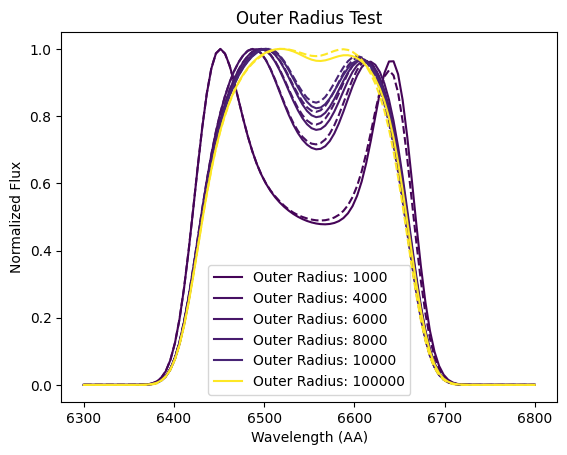

In [5]:
fig, ax = plt.subplots()

for outrad in [1e3, 4e3, 6e3, 8e3, 1e4, 1e5]:
    pmod = param_mods.copy()
    pmod["halpha_disk_outer_radius"] = outrad
    flux, _, _ = evaluate_disk_model(template, wave, pmod)
    ax.plot(wave, flux, label=f"Outer Radius: {outrad:.0f}", color=plt.cm.viridis(outrad / 1e5))

    flux_hung = e_model([
        pmod['halpha_disk_q'],
        pmod['halpha_disk_sigma'],
        pmod['halpha_disk_inclination'],
        pmod['halpha_disk_eccentricity'],
        pmod['halpha_disk_apocenter'],
        pmod['halpha_disk_inner_radius'],
        # pmod['halpha_disk_outer_radius'],
        outrad
        ], X)
    
    ax.plot(wave, flux_hung, linestyle="--",  color=plt.cm.viridis(outrad / 1e5))

ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Normalized Flux")
ax.set_title("Outer Radius Test")
ax.legend()

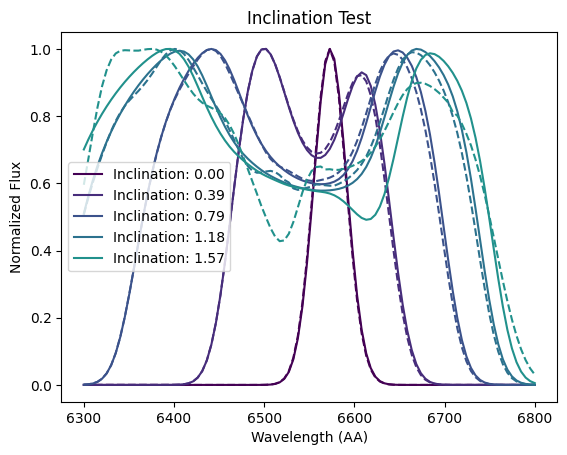

In [6]:
fig, ax = plt.subplots()

for inc in np.linspace(0, np.pi / 2, 5):
    pmod = param_mods.copy()
    pmod["halpha_disk_inclination"] = inc
    flux, _, _ = evaluate_disk_model(template, wave, pmod)
    ax.plot(wave, flux, label=f"Inclination: {inc:.2f}", color=plt.cm.viridis(inc / np.pi))

    flux_hung = e_model([
        pmod['halpha_disk_q'],
        pmod['halpha_disk_sigma'],
        # pmod['halpha_disk_inclination'],
        inc,
        pmod['halpha_disk_eccentricity'],
        pmod['halpha_disk_apocenter'],
        pmod['halpha_disk_inner_radius'],
        pmod['halpha_disk_outer_radius'],
        ], X)
    
    ax.plot(wave, flux_hung, linestyle="--",  color=plt.cm.viridis(inc / np.pi))

ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Normalized Flux")
ax.set_title("Inclination Test")
ax.legend()

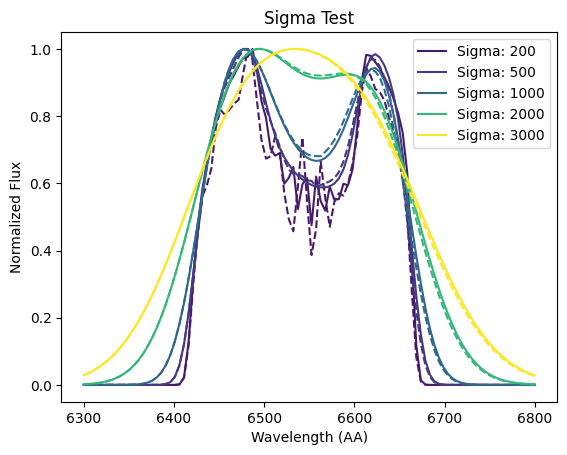

In [7]:
fig, ax = plt.subplots()

for sig in [2e2, 5e2, 1e3, 2e3, 3e3]:
    pmod = param_mods.copy()
    pmod["halpha_disk_sigma"] = sig
    flux, _, _ = evaluate_disk_model(template, wave, pmod)
    ax.plot(wave, flux, label=f"Sigma: {sig:.0f}", color=plt.cm.viridis(sig / 3e3))

    flux_hung = e_model([
        pmod['halpha_disk_q'],
        # pmod['halpha_disk_sigma'],
        sig,
        pmod['halpha_disk_inclination'],
        pmod['halpha_disk_eccentricity'],
        pmod['halpha_disk_apocenter'],
        pmod['halpha_disk_inner_radius'],
        pmod['halpha_disk_outer_radius'],
        ], X)
    
    ax.plot(wave, flux_hung, linestyle="--",  color=plt.cm.viridis(sig / 3e3))

ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Normalized Flux")
ax.set_title("Sigma Test")
ax.legend()

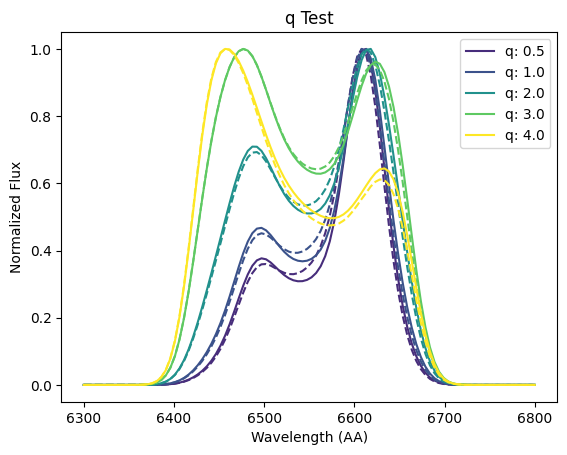

In [8]:
fig, ax = plt.subplots()

for q in [0.5, 1, 2, 3, 4]:
    pmod = param_mods.copy()
    pmod["halpha_disk_q"] = q
    flux, _, _ = evaluate_disk_model(template, wave, pmod)
    ax.plot(wave, flux, label=f"q: {q:.1f}", color=plt.cm.viridis(q / 4))

    flux_hung = e_model([
        # pmod['halpha_disk_q'],
        q,
        pmod['halpha_disk_sigma'],
        pmod['halpha_disk_inclination'],
        pmod['halpha_disk_eccentricity'],
        pmod['halpha_disk_apocenter'],
        pmod['halpha_disk_inner_radius'],
        pmod['halpha_disk_outer_radius'],
        ], X)
    
    ax.plot(wave, flux_hung, linestyle="--",  color=plt.cm.viridis(q / 4))

ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Normalized Flux")
ax.set_title("q Test")
ax.legend()

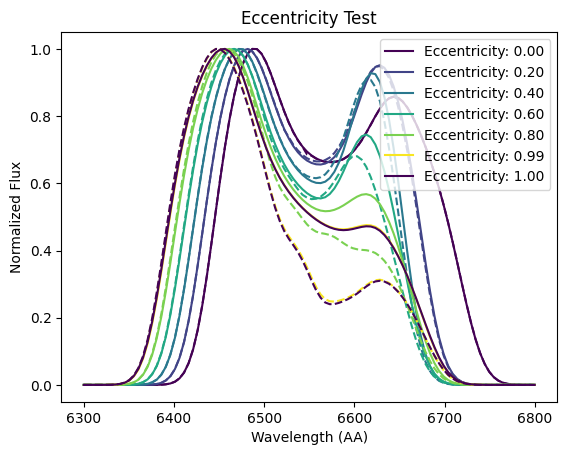

In [9]:
fig, ax = plt.subplots()

for ecc in [0, 0.2, 0.4, 0.6, 0.8, 0.99, 1]:
# for ecc in [0, 0.1, 0.3, 0.5]:
    pmod = param_mods.copy()
    pmod["halpha_disk_eccentricity"] = ecc
    flux, _, _ = evaluate_disk_model(template, wave, pmod)
    ax.plot(wave, flux, label=f"Eccentricity: {ecc:.2f}",  color=plt.cm.viridis(ecc))

    flux_hung = e_model([
        pmod['halpha_disk_q'],
        pmod['halpha_disk_sigma'],
        pmod['halpha_disk_inclination'],
        # pmod['halpha_disk_eccentricity'],
        ecc,
        pmod['halpha_disk_apocenter'],
        pmod['halpha_disk_inner_radius'],
        pmod['halpha_disk_outer_radius'],
        ], X)
    
    ax.plot(wave, flux_hung, linestyle="--",  color=plt.cm.viridis(ecc))

ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Normalized Flux")
ax.set_title("Eccentricity Test")
ax.legend()

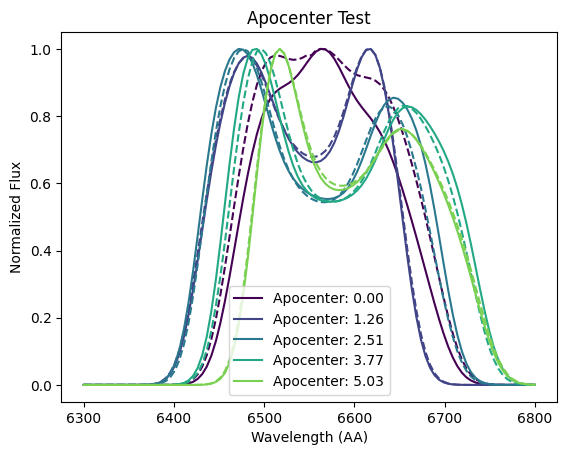

In [10]:
fig, ax = plt.subplots()

for apo in np.arange(0, 2 * np.pi, np.deg2rad(36 * 2)):
    pmod = param_mods.copy()
    pmod["halpha_disk_apocenter"] = apo
    flux, _, _ = evaluate_disk_model(template, wave, pmod)
    ax.plot(wave, flux, label=f"Apocenter: {apo:.2f}",  color=plt.cm.viridis(apo / (2 * np.pi)))

    flux_hung = e_model([
        pmod['halpha_disk_q'],
        pmod['halpha_disk_sigma'],
        pmod['halpha_disk_inclination'],
        pmod['halpha_disk_eccentricity'],
        # pmod['halpha_disk_apocenter'],
        apo,
        pmod['halpha_disk_inner_radius'],
        pmod['halpha_disk_outer_radius'],
        ], X)
    
    ax.plot(wave, flux_hung, linestyle="--",  color=plt.cm.viridis(apo / (2 * np.pi)))

ax.set_xlabel("Wavelength (AA)")
ax.set_ylabel("Normalized Flux")
ax.set_title("Apocenter Test")
ax.legend()

In [11]:
np.rad2deg(6.28)

np.float64(359.817495342157)